<a href="https://colab.research.google.com/github/MoohShadox/MCNN_Training/blob/main/Seance_2_Manipuler_Des_Donnees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Réduction et augmentation de dimensionalité

Dans cette partie on va créer des données jouet et montrer ce qu'un réseau de neurones peut faire et qu'un modèle linéaire ne peut pas faire.

Première idée qui nous viens en tête : Des données non linéaires, polynomiales par exemple.

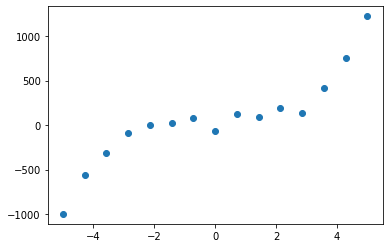

In [ ]:
X = np.linspace(-5,5,15)
Y = 5*X**2 + 8*X**3 + 12*X + 12 + 100*np.random.normal(0,1,X.shape)

plt.scatter(X,Y)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(Y)

In [ ]:
class Regression(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.l1 = nn.Linear(n_in, 1, bias = True)
               
    def forward(self, x):
      return self.l1(x)

In [ ]:
def train_step_constructor(model,loss_f,optimizer):
  def train_step(batch_x, batch_y):
    p = model(batch_x)
    loss = loss_f(batch_y.view((-1,)), p.view((-1,)))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
  return train_step

In [ ]:
model1 = Regression(1)
opt = torch.optim.SGD(model1.parameters() ,lr=1e-1)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model1,mse_loss,opt)

In [ ]:
for i in range(1000):
  l = step(X_tensor.view((-1,1)).float(), y_tensor.float())
print(l)

48603.3671875


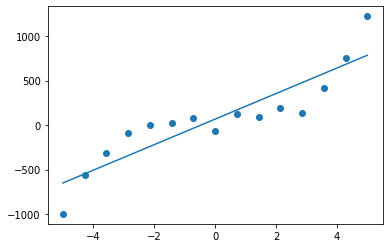

In [ ]:
y_pred = model1(X_tensor.view((-1,1)).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())

Comme on le voit clairement au niveau de l'évolution de la loss qui ne descend pas et au niveau de la figure ça marche absolument pas.

En réalité avant l'existence des réseaux de neurones une technique permettait d'apprendre une fonction plus complexe qu'une combinaison linéaire mais en utilisant une régression linéaire.

L'idée est d'utiliser une regression linéaire mais sur un ensemble de données a plus de colonnes obtenus en faisant une **projection**.

La meilleure projection qu'on puisse imaginer est dans ce cas : 

$\phi(x) = (x, x², x³)$

Pourquoi ?

Parce qu'une regression va apprendre des paramètres $\theta = [a,b,c]$ tel que $$\theta.\phi(X) = y \equiv [a,b,c].[x,x²,x³] = y$$
et donc on apprend la fonction : 
$$y = a.x + b.x² + c.x³$$
Et comme on a généré les données jouet suivant cette fonction on sait qu'elle va bien fonctionner pour la représenter.

In [ ]:
X_resized = np.vstack([X,X**2,X**3]).T
X_resized.shape

(15, 3)

In [ ]:
model2 = Regression(3)
opt = torch.optim.SGD(model2.parameters() ,lr=1e-4)
step = train_step_constructor(model2,mse_loss,opt)
X_tensor = torch.tensor(X_resized)

In [ ]:
for i in range(100000):
  l = step(X_tensor.view((-1,3)).float(), y_tensor.float())
print(l)

2838.42724609375


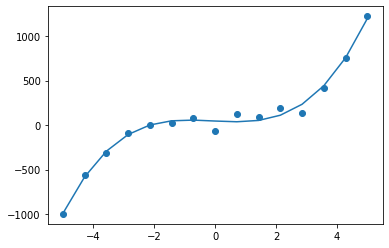

In [ ]:
y_pred = model2(X_tensor.view((-1,3)).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())

In [ ]:
list(model2.parameters())

[Parameter containing:
 tensor([[-17.8259,   2.2569,   9.4611]], requires_grad=True),
 Parameter containing:
 tensor([44.8658], requires_grad=True)]

In [ ]:
class Regression(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.l1 = nn.Linear(n_in, 1, bias = True)
               
    def forward(self, x):
      return self.l1(x)

In [ ]:
def gaussian_kernel(x, center,width = 1):
  n = (x - center)
  n = torch.pow(n,2)
  n = torch.divide(n,width)
  return torch.exp(-n)

  
X = np.linspace(-5,5,100)
Y = 5*X**2+ 12*X + 12 + 2*np.random.normal(0,1,X.shape)

X_tensor = torch.tensor(X)
y_tensor = torch.tensor(Y)

kern_1 = gaussian_kernel(X_tensor, X_tensor[10],width=0.1)
kern_2 = gaussian_kernel(X_tensor, X_tensor[50],width=0.1)
kern_3 = gaussian_kernel(X_tensor, X_tensor[80],width=0.1)

L = [kern_1,kern_2,kern_3]
X_resized = torch.stack(L).T
X_resized.shape

torch.Size([100, 3])

In [ ]:
model2 = Regression(3)
opt = torch.optim.Adam(model2.parameters() ,lr=1e-2)
step = train_step_constructor(model2,mse_loss,opt)
X_tensor = torch.tensor(X_resized)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [ ]:
for i in range(30000):
  l = step(X_tensor.view((-1,3)).float(), y_tensor.float())
print(l)

2418.311279296875


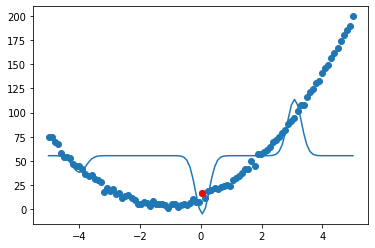

In [ ]:
y_pred = model2(X_tensor.view((-1,3)).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.scatter(X[50],Y[50], c = "red")

In [ ]:
list(model2.parameters())

[Parameter containing:
 tensor([[-17.1198, -60.1434,  58.1569]], requires_grad=True),
 Parameter containing:
 tensor([55.4573], requires_grad=True)]

In [ ]:
X = np.linspace(-5,5,100)
Y = 5*X**2+ 12*X + 12 + 10*np.random.normal(0,1,X.shape)

X_tensor = torch.tensor(X)
y_tensor = torch.tensor(Y)
L = []
for i in range(X_tensor.shape[0]):
  kern_1 = gaussian_kernel(X_tensor, X_tensor[i],width=0.1)
  L.append(kern_1)
X_resized = torch.stack(L).T
X_resized.shape

torch.Size([100, 100])

In [ ]:
model2 = Regression(100)
opt = torch.optim.Adam(model2.parameters() ,lr=1e-2)
step = train_step_constructor(model2,mse_loss,opt)
X_tensor = torch.tensor(X_resized)
for i in range(30000):
  l = step(X_tensor.view((-1,100)).float(), y_tensor.float())
print(l)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


62.517234802246094


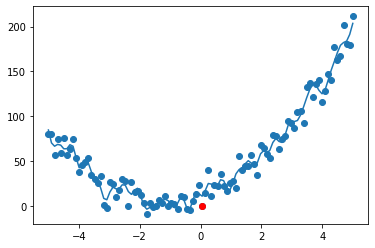

In [ ]:
y_pred = model2(X_tensor.view((-1,100)).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.scatter(X[50],Y[50], c = "red")

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_tensor.detach().numpy())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_t2 = pca.transform(X_tensor.detach().numpy())
X_t2.shape

(100, 10)

316.0047912597656


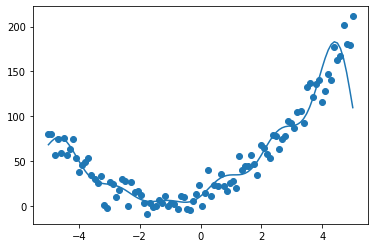

In [ ]:
model2 = Regression(10)
opt = torch.optim.Adam(model2.parameters() ,lr=1e-2)
step = train_step_constructor(model2,mse_loss,opt)
X_tensor = torch.tensor(X_t2)
for i in range(30000):
  l = step(X_tensor.view((-1,10)).float(), y_tensor.float())
print(l)
y_pred = model2(X_tensor.view((-1,10)).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())


Comme on peut le voire un projection permet d'apprendre une fonction qui épouse mieux la courbe de points.

Cependant cette projection a été construite en utilisant des informations dont nous disposions parce qu'on avait construit les y a partir des X mais en général ce n'est jamais le cas.

Ainsi ajouter une couche cachée sert a ça : construire une projection des données facilitant l'apprentissage de la couche suivante.

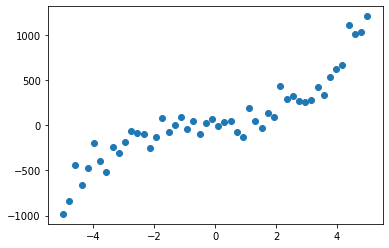

In [ ]:
class D_Regression(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.relu = nn.ReLU()
        self.h1 = nn.Linear(n_in, 3, bias = True) #cette couche prend en paramètres les X et génère une projection en 3 dimensions
        self.o = nn.Linear(3, 1, bias = True)
    

    def forward(self, x):
      x = self.relu(self.h1(x))
      return self.o(x)


X = np.linspace(-5,5,50)
Y = 5*X**2 + 8*X**3 + 12*X + 12 + 100*np.random.normal(0,1,X.shape)
plt.scatter(X,Y)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(Y)

In [ ]:
model3 = D_Regression(1)
opt = torch.optim.Adam(model3.parameters() ,lr=1e-1)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model3,mse_loss,opt)

In [ ]:
for i in range(15000):
  l = step(X_tensor.view((-1,1)).float(), y_tensor.float())
print(l)

12641.5927734375


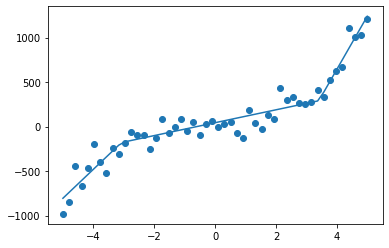

In [ ]:
y_pred = model3(X_tensor.view((-1,1)).float())
plt.scatter(X_tensor,Y)
plt.plot(X_tensor,y_pred.detach().numpy())

In [ ]:
class D_Regression2(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.relu = nn.ReLU()
        self.h1 = nn.Linear(n_in, 16, bias = True)
        self.o = nn.Linear(16, 1, bias = True)
    
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      return self.o(x)


In [ ]:
X = np.linspace(-5,5,50)
Y = 5*X**2 + 8*X**3 + 12*X + 12 + 100*np.random.normal(0,1,X.shape)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(Y)

In [ ]:
model4 = D_Regression2(1)
opt = torch.optim.Adam(model4.parameters() ,lr=1e-2)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model4,mse_loss,opt)

In [ ]:
for i in range(20000):
  l = step(X_tensor.view((-1,1)).float(), y_tensor.float())
print(l)

7330.8349609375


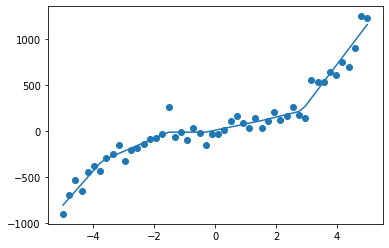

In [ ]:
y_pred = model4(X_tensor.view((-1,1)).float())
plt.scatter(X_tensor,Y)
plt.plot(X_tensor,y_pred.detach().numpy())

In [ ]:
y_t = 5*X**2 + 8*X**3 + 12*X + 12
((y_t-Y)**2).mean()

8580.416025522158

In [ ]:
class D_Regression2(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.relu = nn.ReLU()
        self.h1 = nn.Linear(n_in, 100, bias = True)
        self.h2 = nn.Linear(100, 10, bias = True)
        self.o = nn.Linear(10, 1, bias = True)
    
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.relu(self.h2(x))
      return self.o(x)


In [ ]:
model3 = D_Regression(1)
opt = torch.optim.Adam(model3.parameters() ,lr=1e-1)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model3,mse_loss,opt)

In [ ]:
for i in range(20000):
  l = step(X_tensor.view((-1,1)).float(), y_tensor.float())
print(l)

8320.724609375


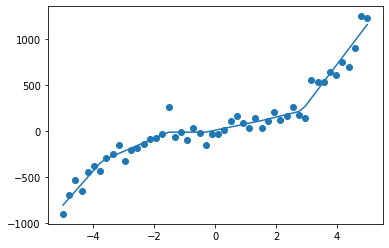

In [ ]:
y_pred = model4(X_tensor.view((-1,1)).float())
plt.scatter(X_tensor,Y)
plt.plot(X_tensor,y_pred.detach().numpy())

# Overfitting et Underfitting
Le sur-apprentissage désigne un phénomène survenant quand le modèle adapte ces paramètres afin d'essayer d'expliquer du bruit lié au données plûtot que le phenomène sous-jacent.

Ici on va présenter les phenomènes d'overfitting et d'underfitting et montrer quand-est ce qu'ils peuvent survenir.


## Sur-apprentissage du modèle

Ici on va présenter quelques exemples qui vont intuitivement montrer le sur-apprentissage et le sous-apprentissage pouvant survenir au moment de la définition du modèle.

Ensuite nous allons montrer un moyen simple de combattre ce sur-apprentissage.

Pour se faire reprenons notre exemple jouet précédent car le bruit et le phénomène sont facilement distinguable.

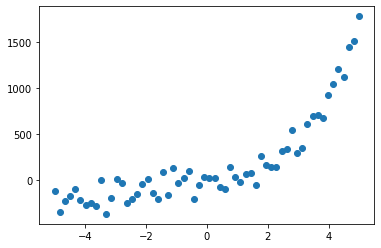

In [ ]:
X = np.linspace(-5,5,60)
Y_true = X**4 + 8*X**3 + 5*X**2  + 12*X + 12 #Modèle
Y = Y_true + 100*np.random.normal(0,1,X.shape) #Données qu'on utilisera pour l'apprentissage (elles sont bruités c'est normal)
plt.scatter(X,Y)

### L'erreur irréductible

Une partie de l'erreur est appelée erreur **irréductible**, c'est l'erreur qu'on ne peut pas ou qu'on ne cherche pas a prédire.

Donc normalement si on arrive a modéliser **parfaitement** le phénomène on devrais avoir la loss suivante : 

In [ ]:
((Y - Y_true)**2).mean()

10819.4887092763

### Relation entre la compléxité du modèle et la loss

Dans ce qui suit on va utiliser l'ancienne méthode pour effectuer une régression non-linéaire qui consiste a projeter les données, et on va essayez d'évaluer l'impact du nombre de variables du modèle sur ces performances.

Commençons par prendre un modèle avec autant de variable que le phénomène réel.

In [ ]:
#Fonction qui projete les variables sur plusieurs colonnes
def ajouter_projection(X):
  X_resized = np.vstack([X,X**2,X**3,X**4]).T
  return X_resized


class Regression(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.l1 = nn.Linear(n_in, 1, bias = True)
               
    def forward(self, x):
      return self.l1(x)

In [ ]:
X_2 = torch.tensor(ajouter_projection(X))
model = Regression(X_2.shape[1])
opt = torch.optim.Adam(model.parameters() ,lr=1e-3)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model,mse_loss,opt)

In [ ]:
for i in range(10000):
  l = step(X_2.view((-1,X_2.shape[1])).float(), torch.tensor(Y,dtype=torch.float))
print(l)

11001.0517578125


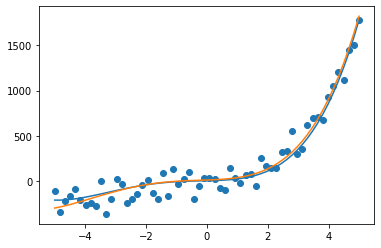

In [ ]:
y_pred = model(X_2.view((-1,X_2.shape[1])).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.plot(X,Y_true)

On constate que la loss obtenue aprés quelques épisodes d'entrainement est proche de l'erreur irréductible, donc le modèle n'overfit pas a priori.

Maintenant essayons de diminuer la complexité du modèle en diminuant le nombre de variables qu'il va construire.

17808.185546875


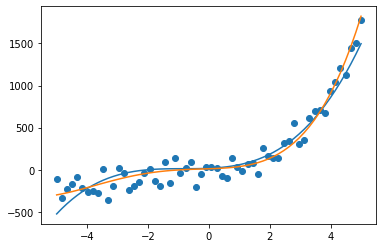

In [ ]:
def ajouter_projection(X):
  X_resized = np.vstack([X,X**2,X**3]).T
  return X_resized


X_2 = torch.tensor(ajouter_projection(X))
model = Regression(X_2.shape[1])
opt = torch.optim.Adam(model.parameters() ,lr=1e-3)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model,mse_loss,opt)

for i in range(20000):
  l = step(X_2.view((-1,X_2.shape[1])).float(), torch.tensor(Y,dtype=torch.float))
print(l)

y_pred = model(X_2.view((-1,X_2.shape[1])).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.plot(X,Y_true)

Le modèle galère beaucoup plus la loss est plus grande et ce malgré le fait qu'on ait augementé le nombre d'itérations, 

Diminuons une fois de plus le nombre de paramètres et voyons ce qui se passe.

124636.28125


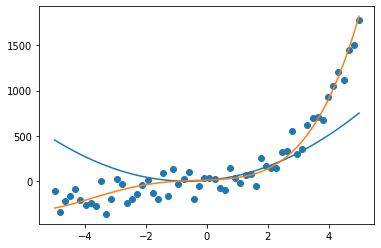

In [ ]:
def ajouter_projection(X):
  X_resized = np.vstack([X,X**2]).T
  return X_resized



X_2 = torch.tensor(ajouter_projection(X))
model = Regression(X_2.shape[1])
opt = torch.optim.Adam(model.parameters() ,lr=1e-3)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model,mse_loss,opt)

for i in range(30000):
  l = step(X_2.view((-1,X_2.shape[1])).float(), torch.tensor(Y,dtype=torch.float))
print(l)

y_pred = model(X_2.view((-1,X_2.shape[1])).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.plot(X,Y_true)

On voit bien que la courbe essaye le plus possible de coller au vrai phenomène mais que la complexité du modèle ne permet simplement plus d'apprendre le phenomène.

A présent essayons de prendre le contre-sens de ce qu'on a fait, et essayons de créer un modèle beaucoup plus complexe que le vrai modèle et voyons ce qui se passe.

9390.2119140625


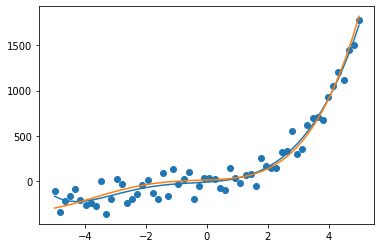

In [ ]:
def ajouter_projection(X):
  X_resized = np.vstack([X,X**2,X**3,X**4,X**5, X**6]).T
  return X_resized


X_2 = torch.tensor(ajouter_projection(X))
model = Regression(X_2.shape[1])
opt = torch.optim.Adam(model.parameters() ,lr=1e-3)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model,mse_loss,opt)

for i in range(30000):
  l = step(X_2.view((-1,X_2.shape[1])).float(), torch.tensor(Y,dtype=torch.float))
print(l)

y_pred = model(X_2.view((-1,X_2.shape[1])).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.plot(X,Y_true)

Donc ici la la courbe épouse parfaitement bien les points, mais même un peu trop en réalité car on voit bien qu'a certains endroits elle colle tellement aux points qu'elle s'éloigne du vrai phenomène.

De plus on voit que la loss est inférieur a l'erreur irréductible ce qui signifie que le modèle est entrain de calibrer ces paramètres pour prédire du "bruit".

### La Régularisation : Un moyen de combattre les paramètres inutiles

Un moyen d'éviter qu'un modèle utilise plus de paramètres que ce qui est nécéssaire est de le pénaliser a hauteur de la somme des valeurs de ces paramètres pour l'inciter a avoir le plus possible de paramètres a 0.

Cette technique de régularisation s'appelle la L1-Régularisation, une autre technique consiste a pénaliser par la somme des carrés des paramètres ce qui a pour effet de moins les pénaliser quand ils sont en dessous de 1 ce qui fait que moins de paramètres s'annulent.

La régularisation dépend dans tous les cas d'un coefficient de régularisation qui indique a quel point on privilégie la simplicité du modèle au fait qu'il colle aux données.

Reprenons l'exemple précédent avec plein de complexité en trop et expérimentons chaque régularisation.

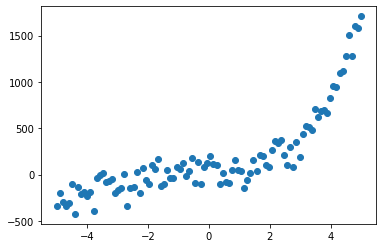

In [ ]:
X = np.linspace(-5,5,100)
Y_true = X**4 + 8*X**3 + 5*X**2  + 12*X + 12 #Modèle
Y = Y_true + 100*np.random.normal(0,1,X.shape) #Données qu'on utilisera pour l'apprentissage (elles sont bruités c'est normal)
plt.scatter(X,Y)

In [ ]:
def train_step_constructor(model,loss_f,optimizer, lambda_ ,norm = 1):
  def train_step(batch_x, batch_y):
    p = model(batch_x)
    #On récupère et on concatène les valeurs de tous les paramètres du modèle
    params = torch.cat( [x.view(-1) for x in model.parameters()] )
    #On calcule leur norme qu'on ajoute a la loss
    loss = loss_f(batch_y.view((-1,)), p.view((-1,))) + lambda_ * torch.norm(params,p = norm)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
  return train_step

loss =  10558.85546875
parametres :  [Parameter containing:
tensor([[ 8.9821e+00, -1.5506e+00,  8.9982e+00,  1.4597e+00, -1.5848e-01,
         -1.3107e-02,  4.5569e-03]], requires_grad=True), Parameter containing:
tensor([39.8437], requires_grad=True)]


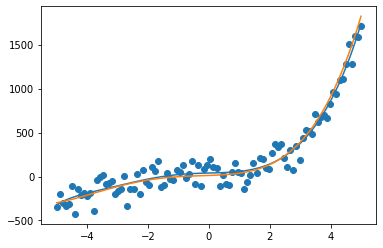

In [ ]:
def ajouter_projection(X):
  X_resized = np.vstack([X,X**2,X**3,X**4,X**5, X**6, X**7]).T
  return X_resized


X_2 = torch.tensor(ajouter_projection(X))
model = Regression(X_2.shape[1])
opt = torch.optim.Adam(model.parameters() ,lr=1e-2)
mse_loss = nn.MSELoss(reduction='mean')

step = train_step_constructor(model,mse_loss,opt,lambda_=0, norm=1)

for i in range(30000):
  l = step(X_2.view((-1,X_2.shape[1])).float(), torch.tensor(Y,dtype=torch.float))
print("loss = " , l)
print("parametres : ", list(model.parameters()))
y_pred = model(X_2.view((-1,X_2.shape[1])).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.plot(X,Y_true)

loss =  11337.7119140625
parametres :  [Parameter containing:
tensor([[-1.0330e-03,  5.7457e+00,  1.0767e+01,  9.7707e-01, -2.6453e-01,
         -3.4548e-03,  6.5385e-03]], requires_grad=True), Parameter containing:
tensor([7.3789], requires_grad=True)]


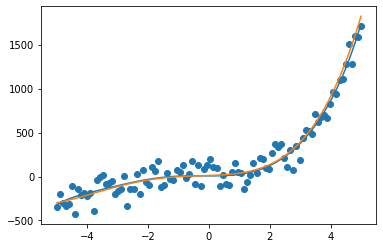

In [ ]:
def ajouter_projection(X):
  X_resized = np.vstack([X,X**2,X**3,X**4,X**5, X**6, X**7]).T
  return X_resized


X_2 = torch.tensor(ajouter_projection(X))
model = Regression(X_2.shape[1])
opt = torch.optim.Adam(model.parameters() ,lr=1e-2)
mse_loss = nn.MSELoss(reduction='mean')

step = train_step_constructor(model,mse_loss,opt,lambda_=2e1, norm=1)

for i in range(30000):
  l = step(X_2.view((-1,X_2.shape[1])).float(), torch.tensor(Y,dtype=torch.float))
print("loss = " , l)
print("parametres : ", list(model.parameters()))
y_pred = model(X_2.view((-1,X_2.shape[1])).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.plot(X,Y_true)

loss =  11072.5703125
parametres :  [Parameter containing:
tensor([[ 3.4376e+00,  6.4418e+00,  1.0161e+01,  8.3256e-01, -2.3224e-01,
          1.1379e-03,  6.0142e-03]], requires_grad=True), Parameter containing:
tensor([12.3555], requires_grad=True)]


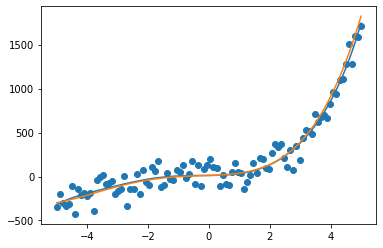

In [ ]:
def ajouter_projection(X):
  X_resized = np.vstack([X,X**2,X**3,X**4,X**5, X**6, X**7]).T
  return X_resized


X_2 = torch.tensor(ajouter_projection(X))
model = Regression(X_2.shape[1])
opt = torch.optim.Adam(model.parameters() ,lr=1e-2)
mse_loss = nn.MSELoss(reduction='mean')

step = train_step_constructor(model,mse_loss,opt,lambda_=2e1, norm=2)

for i in range(30000):
  l = step(X_2.view((-1,X_2.shape[1])).float(), torch.tensor(Y,dtype=torch.float))
print("loss = " , l)
print("parametres : ", list(model.parameters()))
y_pred = model(X_2.view((-1,X_2.shape[1])).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.plot(X,Y_true)

## Sur-apprentissage lors de l'entrainement

Parfois un modèle qui n'est pas plus complexe que le phénomène mais pourtant l'entrainement qui lui fait minimiser une loss tend a le faire sur-interp
réter.

Reprenons un exemple précédent avec peu de complexité et augmentant alpha et le nombre d'epochs.

10611.099609375


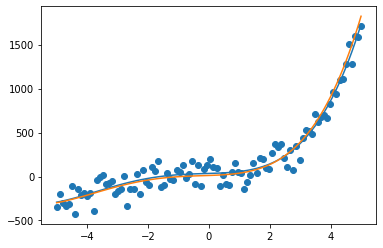

In [ ]:
#On reprend celui qui ne régularize pas
def train_step_constructor(model,loss_f,optimizer):
  def train_step(batch_x, batch_y):
    p = model(batch_x)
    loss = loss_f(batch_y.view((-1,)), p.view((-1,)))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
  return train_step


def ajouter_projection(X):
  X_resized = np.vstack([X,X**2,X**3, X**4]).T
  return X_resized


X_2 = torch.tensor(ajouter_projection(X))
model = Regression(X_2.shape[1])
opt = torch.optim.Adam(model.parameters() ,lr=1e-2)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model,mse_loss,opt)

for i in range(50000):
  l = step(X_2.view((-1,X_2.shape[1])).float(), torch.tensor(Y,dtype=torch.float))
print(l)

y_pred = model(X_2.view((-1,X_2.shape[1])).float())
plt.scatter(X,Y)
plt.plot(X,y_pred.detach().numpy())
plt.plot(X,Y_true)

Comme on peut le voire le sur-apprentissage peut survenir si on entraine le modèle pendant trop longtemps.

### Early Stopping

La première idée pour éviter ce genre de problèmes est de détecter le sur-apprentissage afin de stopper l'entrainement de façon prématurée si il survient.

Une des façons les plus simples pour détecter le sur-apprentissage consiste a utiliser une partie des données pour le test et une autre majoritaire pour l'entrainement.

ça on vera toutes les méthodes de **cross-validation** dans la partie dédiée a 
ça.

### Ajouter des drop-out

Un dropout est un mécanisme qui permet de désactiver un ou plusieurs neuronnes 

In [ ]:
class D_Regression2(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.relu = nn.ReLU()
        self.h1 = nn.Linear(n_in, 32, bias = True)
        self.h2 = nn.Linear(32, 64, bias = True)
        self.o = nn.Linear(64, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.relu(self.h2(x))
      return self.o(x)

In [ ]:
X = np.linspace(-5,5,60)
Y_true = X**4 + 8*X**3 + 5*X**2  + 12*X + 12 #Modèle
Y = Y_true + 100*np.random.normal(0,1,X.shape) #Données qu'on utilisera pour l'apprentissage (elles sont bruités c'est normal)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(Y)

In [ ]:
model4 = D_Regression2(1)
opt = torch.optim.Adam(model4.parameters() ,lr=1e-2)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model4,mse_loss,opt)

In [ ]:
for i in range(20000):
  l = step(X_tensor.view((-1,1)).float(), y_tensor.float())
print(l)

8408.7958984375


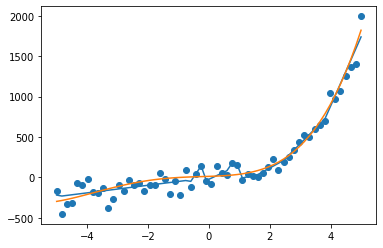

In [ ]:
y_pred = model4(X_tensor.view((-1,1)).float())
plt.scatter(X_tensor,Y)
plt.plot(X_tensor,y_pred.detach().numpy())
plt.plot(X,Y_true)

9391.2587890625


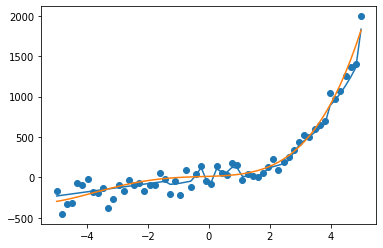

In [ ]:
class D_Regression2(nn.Module):
    def __init__(self, n_in, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        #Voila la couche de Dropout il prend en paramètres la probabilité de desactiver un neurone
        self.drop = nn.Dropout(p)
        self.h1 = nn.Linear(n_in, 32, bias = True)
        self.h2 = nn.Linear(32, 64, bias = True)
        self.o = nn.Linear(64, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.drop(x)
      x = self.relu(self.h2(x))
      x = self.drop(x)
      return self.o(x)


model4 = D_Regression2(1)
opt = torch.optim.Adam(model4.parameters() ,lr=1e-2)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model4,mse_loss,opt)

#Active les dropout
model4.train()


for i in range(20000):
  l = step(X_tensor.view((-1,1)).float(), y_tensor.float())
print(l)

#Le désactive pour la prédiction
model4.eval()
y_pred = model4(X_tensor.view((-1,1)).float())
plt.scatter(X_tensor,Y)
plt.plot(X_tensor,y_pred.detach().numpy())
plt.plot(X,Y_true)

16383.3173828125


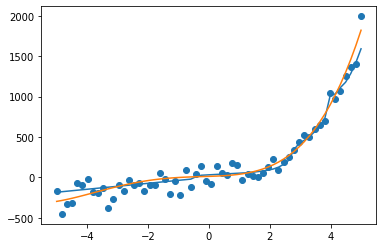

In [ ]:
model4 = D_Regression2(1,p= 0.5)
opt = torch.optim.Adam(model4.parameters() ,lr=1e-2)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model4,mse_loss,opt)

#Active les dropout
model4.train()


for i in range(30000):
  l = step(X_tensor.view((-1,1)).float(), y_tensor.float())
print(l)

#Le désactive pour la prédiction
model4.eval()
y_pred = model4(X_tensor.view((-1,1)).float())
plt.scatter(X_tensor,Y)
plt.plot(X_tensor,y_pred.detach().numpy())
plt.plot(X,Y_true)

## Sur-apprentissage des données

Cette partie est une bonne occasion pour expliquer la différence entre sur-apprentissage est sur-interprétation.

Les deux termes sont souvent utilisés de façon interchangeable, et en anglais la sur-interprétation n'a pas son équivalent.

Pourtant la différence entre les deux termes est très intuitive, le premier signifie que le modèle apprend du bruit et le second que le modèle interpéte les données au dela de leur capacités de représentation.


Par exemple dans nos exemples jouets, imaginons qu'on ait un ensemble de X entre -10 et 10 et qu'on le partage 50/50.
L'apprentissage d'un modèle sur la première partie conduira nécessairement de la sur-interprétation de la deuxième partie car le modèle pensera qu'il a appris des relations a partir de données représentative de tout l'intervalle et donc sur-interpréter les relations qu'il a apprise (les interpréter plus que ce qu'elles ne veulent dire).

Un exemple de la vie courante de sur-interprétation se trouve dans tous les examens de littérature, si on apprennais a repondre la question "quel est la figure de style dans le passage [...]" répondre tout le temps "Métaphore" conduirait a une précision relativement elevée mais pourtant ça serait de la sur-interprétation des examens qui ne représentent pas l'ensemble des figures de style qu'on peut trouver.


### Cross-validation
Une des façon de détecter le sur-apprentissage est de diviser les données et de voire si le modèle sur-interpréte les données d'entrainement (si il apprend des choses qui n'existent pas dans l'ensemble de test)

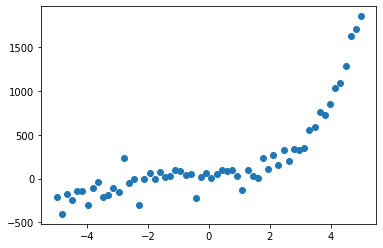

In [ ]:
X = np.linspace(-5,5,60)
Y_true = X**4 + 8*X**3 + 5*X**2  + 12*X + 12 #Modèle
Y = Y_true + 100*np.random.normal(0,1,X.shape) #Données qu'on utilisera pour l'apprentissage (elles sont bruités c'est normal)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(Y)
plt.scatter(X,Y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor)

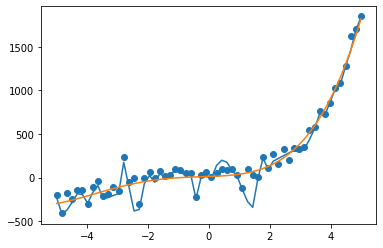

In [ ]:
class D_Regression2(nn.Module):
    def __init__(self, n_in, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        #Voila la couche de Dropout il prend en paramètres la probabilité de desactiver un neurone
        self.drop = nn.Dropout(p)
        self.h1 = nn.Linear(n_in, 32, bias = True)
        self.h2 = nn.Linear(32, 64, bias = True)
        self.h3 = nn.Linear(64, 128, bias = True)
        self.o = nn.Linear(128, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.drop(x)
      x = self.relu(self.h2(x))
      x = self.drop(x)
      x = self.relu(self.h3(x))
      x = self.drop(x)
      return self.o(x)



model4 = D_Regression2(1,p= 0.0)
opt = torch.optim.Adam(model4.parameters() ,lr=1e-2)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model4,mse_loss,opt)

losses, val_losses=[], []

for i in range(30000):
  model4.train()
  l = step(X_train.view((-1,1)).float(), y_train.float())
  losses.append(l)
  model4.eval()
  y_pred = model4(X_test.view((-1,1)).float())
  val_loss = mse_loss(y_pred.view((-1,)), y_test.view((-1,)))
  val_losses.append(val_loss)



y_pred = model4(X_tensor.view((-1,1)).float())
plt.scatter(X_tensor,Y)
plt.plot(X_tensor,y_pred.detach().numpy())
plt.plot(X,Y_true)

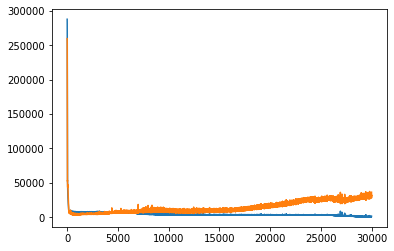

In [ ]:
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(val_losses)),val_losses)


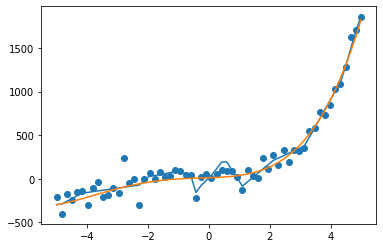

In [ ]:
class D_Regression2(nn.Module):
    def __init__(self, n_in, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        #Voila la couche de Dropout il prend en paramètres la probabilité de desactiver un neurone
        self.drop = nn.Dropout(p)
        self.h1 = nn.Linear(n_in, 32, bias = True)
        self.h2 = nn.Linear(32, 64, bias = True)
        self.h3 = nn.Linear(64, 128, bias = True)
        self.o = nn.Linear(128, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.drop(x)
      x = self.relu(self.h2(x))
      x = self.drop(x)
      x = self.relu(self.h3(x))
      x = self.drop(x)
      return self.o(x)



model4 = D_Regression2(1,p= 0.0)
opt = torch.optim.Adam(model4.parameters() ,lr=1e-4)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model4,mse_loss,opt)

losses, val_losses=[], []

for i in range(30000):
  model4.train()
  l = step(X_train.view((-1,1)).float(), y_train.float())
  losses.append(l)
  model4.eval()
  y_pred = model4(X_test.view((-1,1)).float())
  val_loss = mse_loss(y_pred.view((-1,)), y_test.view((-1,)))
  val_losses.append(val_loss)



y_pred = model4(X_tensor.view((-1,1)).float())
plt.scatter(X_tensor,Y)
plt.plot(X_tensor,y_pred.detach().numpy())
plt.plot(X,Y_true)

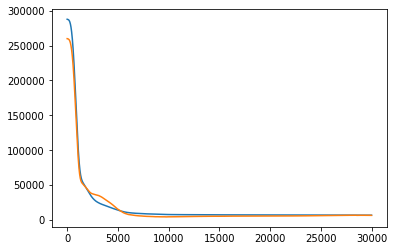

In [ ]:
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(val_losses)),val_losses)

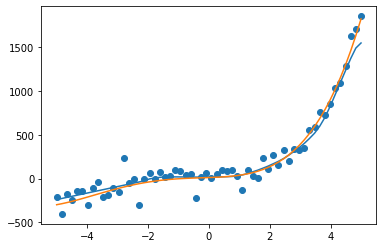

In [ ]:
class D_Regression2(nn.Module):
    def __init__(self, n_in, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        #Voila la couche de Dropout il prend en paramètres la probabilité de desactiver un neurone
        self.drop = nn.Dropout(p)
        self.h1 = nn.Linear(n_in, 32, bias = True)
        self.h2 = nn.Linear(32, 64, bias = True)
        self.h3 = nn.Linear(64, 128, bias = True)
        self.o = nn.Linear(128, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.drop(x)
      x = self.relu(self.h2(x))
      x = self.drop(x)
      x = self.relu(self.h3(x))
      x = self.drop(x)
      return self.o(x)



model4 = D_Regression2(1,p= 0.4)
opt = torch.optim.Adam(model4.parameters() ,lr=1e-4)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model4,mse_loss,opt)

losses, val_losses=[], []

for i in range(30000):
  model4.train()
  l = step(X_train.view((-1,1)).float(), y_train.float())
  losses.append(l)
  model4.eval()
  y_pred = model4(X_test.view((-1,1)).float())
  val_loss = mse_loss(y_pred.view((-1,)), y_test.view((-1,)))
  val_losses.append(val_loss)



y_pred = model4(X_tensor.view((-1,1)).float())
plt.scatter(X_tensor,Y)
plt.plot(X_tensor,y_pred.detach().numpy())
plt.plot(X,Y_true)

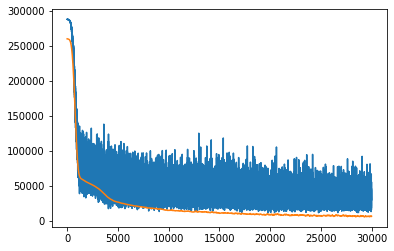

In [ ]:
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(val_losses)),val_losses)

Le problème avec cette méthode c'est qu'elle se rend dépendante de la division des données qui a été faite au début, d'ou l'intéret de la K-Fold Validation.

### K-Fold Validation

In [ ]:
class D_Regression2(nn.Module):
    def __init__(self, n_in, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        self.h1 = nn.Linear(n_in, 32, bias = True)
        self.o = nn.Linear(32, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.drop(x)
      return self.o(x)

8295.646498804932

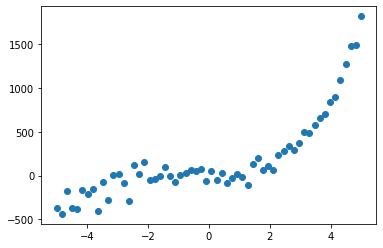

In [ ]:
X = np.linspace(-5,5,60)
Y_true = X**4 + 8*X**3 + 5*X**2  + 12*X + 12 #Modèle
Y = Y_true + 100*np.random.normal(0,1,X.shape) #Données qu'on utilisera pour l'apprentissage (elles sont bruités c'est normal)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(Y)
plt.scatter(X,Y)
((Y-Y_true)**2).mean()

In [ ]:
def train(model, opt, X_train, y_train, epochs = 10000):
  mse_loss = nn.MSELoss(reduction='mean')
  step = train_step_constructor(model,mse_loss,opt)
  model.train()
  for i in range(epochs):
    model.train()
    l = step(X_train.view((-1,1)).float(), y_train.float())
  return model

def evaluate(model, X_test, y_test):
  model.eval()
  mse_loss = nn.MSELoss(reduction='mean')
  y_pred = model(X_test.view((-1,1)).float())
  return (mse_loss(y_pred.view((-1,)), y_test.view((-1,)))).item()

def plot_model(model,X,y,y_true):
  y_pred = model(X.view((-1,1)).float())
  plt.scatter(X,y)
  plt.plot(X,y_pred.detach().numpy())
  plt.plot(X,y_true)

In [ ]:
model = D_Regression2(1,p= 0.10)
opt = torch.optim.Adam(model.parameters() ,lr=1e-1)
model = train(model,opt,X_tensor, y_tensor, epochs = 20000)
evaluate(model, X_tensor, y_tensor)

6799.851807378795

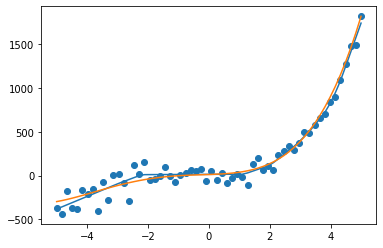

In [ ]:
plot_model(model,X_tensor,y_tensor,Y_true)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
kf.get_n_splits(X_tensor)
print(kf)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]

KFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] TEST: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]


In [ ]:
kf = KFold(n_splits=4)
kf.get_n_splits(X_tensor)
val_losses = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]
    model = D_Regression2(1,p= 0.10)
    opt = torch.optim.Adam(model.parameters() ,lr=1e-1)
    model = train(model,opt,X_tensor, y_tensor, epochs = 5000)
    val_loss = evaluate(model, X_tensor, y_tensor)
    val_losses.append(val_loss)

print(val_losses)

[6837.645968792667, 7404.186813178474, 7112.916330188917, 6823.057744451839]


In [ ]:
#Dans une fonction c'est bien aussi : 
def cross_val(model, n_splits, epochs = 5000, alpha = 1e-1):
  kf = KFold(n_splits=4)
  kf.get_n_splits(X_tensor)
  val_losses = []
  for train_index, test_index in kf.split(X):
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]
    opt = torch.optim.Adam(model.parameters() ,lr=alpha)
    model = train(model,opt,X_tensor, y_tensor, epochs = epochs)
    val_loss = evaluate(model, X_tensor, y_tensor)
    val_losses.append(val_loss)
  return val_losses

In [ ]:

class D_Regression2(nn.Module):
    def __init__(self, n_in, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        self.h1 = nn.Linear(n_in, 32, bias = True)
        self.o = nn.Linear(32, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.drop(x)
      return self.o(x)

model = D_Regression2(1, p = 0.2)
val_losses1 = cross_val(model, 10)

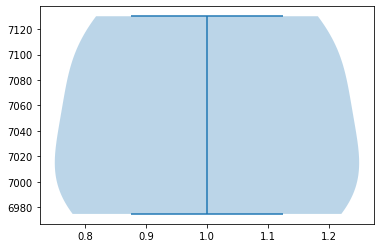

In [ ]:
data_to_plot = [val_losses1, ]
bp = plt.violinplot(data_to_plot)

In [ ]:

class Deep_Regression(nn.Module):
    def __init__(self, n_in, hidden = 32, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        self.h1 = nn.Linear(n_in, hidden, bias = True)
        self.o = nn.Linear(hidden, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.drop(x)
      return self.o(x)




In [ ]:
data_to_plot = []
means = []
for i in range(2,10):
  model = Deep_Regression(1, p = 0.0,hidden = i*5)
  val_losses = cross_val(model, 10, epochs= 5000)
  data_to_plot.append(val_losses)
  val_losses = np.array(val_losses)
  print(val_losses)
  means.append(val_losses.mean())

[6740.54287033 6723.90266734 6727.17454236 6723.6941671 ]
[6922.1256191  6922.33784306 6922.65978458 6923.67705413]
[6618.68950528 6617.89640302 6619.52771276 6617.92299164]
[6690.54478905 6324.922913   6306.82216492 6305.89099792]
[6800.31437724 6724.90057089 6724.40966915 6725.03791426]
[6472.59067522 6451.2084466  6446.71748646 6453.33199634]
[6513.63496354 6498.63981635 6501.36796265 6498.77681989]
[6499.88636171 6499.37446488 6500.17939672 6500.22306227]


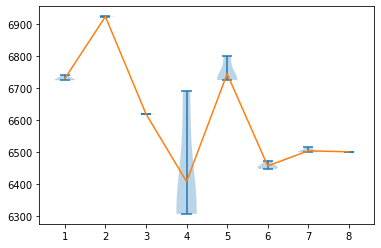

In [ ]:
bp = plt.violinplot(data_to_plot)
plt.plot(np.arange(len(means))+1 , means)

## Tensorboard

Tensorboard est un outil développé a la base pour l'outi Tensorflow (que nous verrons si on a le temps) mais dont plusieurs extensions existent et notamment pour pyTorch, il permet d'enregistrer et d'afficher l'évolution de l'entrainement en temps réel et différents visuels (on en vera dans les séances suivantes).

684493.2540169294

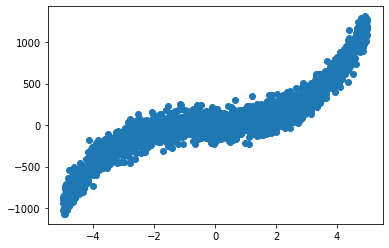

In [ ]:
from torch.utils.tensorboard import SummaryWriter
X = np.linspace(-5,5,2000)
Y = 5*X**2 + 8*X**3 + 12*X + 12 + 100*np.random.normal(0,1,X.shape)
plt.scatter(X,Y)
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(Y)
((Y - 5*X**2 + 8*X**3 + 12*X)**2).mean()

In [ ]:
!rm -rf runs

In [ ]:
class D_Regression2(nn.Module):
    def __init__(self, n_in, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        #Voila la couche de Dropout il prend en paramètres la probabilité de desactiver un neurone
        self.h1 = nn.Linear(n_in, 12, bias = True)
        self.o = nn.Linear(12, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      return self.o(x)
      
def train_step_constructor(model,loss_f,optimizer):
  def train_step(batch_x, batch_y):
    p = model(batch_x)
    loss = loss_f(batch_y.view((-1,)), p.view((-1,)))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
  return train_step

In [ ]:
writer = SummaryWriter()

criterion = nn.MSELoss()
model4 = D_Regression2(1,p= 0.0)
opt = torch.optim.SGD(model4.parameters() ,lr=1e-4)
mse_loss = nn.MSELoss(reduction='mean')
step = train_step_constructor(model4,mse_loss,opt)

losses, val_losses=[], []

for i in range(10000):
  model4.train()
  l = step(X_tensor.view((-1,1)).float(), y_tensor.float())
  losses.append(l)
  model4.eval()
  y_pred = model4(X_tensor.view((-1,1)).float())
  val_loss = mse_loss(y_pred.view((-1,)), y_tensor.view((-1,)))
  val_losses.append(val_loss)
  if(i%100 == 0):
    writer.add_scalar('Loss/train',l,i)
    writer.add_scalar('Loss/Test',val_loss,i)
print('Finished Training')
writer.flush()
writer.close()

Finished Training


In [ ]:
!ls

runs  sample_data  winequality-white.csv  winequality-white.csv.1


In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir "runs"

Reusing TensorBoard on port 6006 (pid 2921), started 2:43:02 ago. (Use '!kill 2921' to kill it.)

<IPython.core.display.Javascript object>

# Application a des données réelles 

Regardons rapidement un workflow classique qu'on utilise durant la conception d'un réseau de neurones pour une tâche simple.

La tâche que nous allons considérer sera une regression pour commencer car vous êtes familiers au concept, 

Je vais traverser toutes les étapes en les expliquant une par une sur un cas d'application mais gardez a l'esprit que en pratique il est possible que vous soyez confrontés a des problèmes que je n'aurais pas croisé sur cet ensemble de données en particulier.

## ETL : Extract, Transform, Load

Une des parties qui sera le plus amenée a varier d'un cas d'applicationa a l'autre est celles des pré-traitement, c'est une étape cruciale dans la mesure ou les réseaux de neurones comme tout les modèles d'inférence obeissent a la règle "Trash in - Trash out".

En réalité cette partie pourrait déja faire l'objet d'une formation sur la conception de **Data Pipelines** mais nous verons rapidement dans une partie ultérieur la différence entre le développement et la production d'un réseau de neurones.

En ce qui nous concerne on fais du développement, donc nos datasets sont connus, fixes, et on n'a a les extraire et a les transformer qu'une seul fois puis on peut les load autant de fois qu'on veut.

De plus dans ce cas précis on se place dans un contexte bien particulier car on suppose que le dataset tient en entier sur la RAM, ce qui est rarement le cas comme nous le verrons quand nous serrons ammenés a manipuler des images.

Après la fin de la partie démonstrations je vous inviterais a chacun choisir un ensemble de données parmi ceux la que j'ai pré-choisis pour vous sur sur [ce](https://archive.ics.uci.edu/ml/index.php) site : 

- [Forest Fires](https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/)
- [Solare Flare](https://archive.ics.uci.edu/ml/machine-learning-databases/solar-flare/)
- [Breast Cancer](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/)
- [Air foil self noise](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)

Celui que je vais prendre pour la démonstration sera : 
[White Wine Quality](http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv)

Commençons par l'ingestion de données, une fois les données récupérées un **Dataset** construit il faut définir un **DataLoader** qui permettra d'en générer des batchs (sous ensemble de données) dynamiquement.


In [2]:
!ls

sample_data


In [3]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

--2021-01-30 13:10:25--  http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv’

winequality-white.c 100%[===================>] 258.23K   881KB/s    in 0.3s    

2021-01-30 13:10:25 (881 KB/s) - ‘winequality-white.csv’ saved [264426/264426]



In [4]:
!ls

sample_data  winequality-white.csv


In [5]:
#Pour ouvrir un CSV on utilise traditionnellement pandas
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt

df = pd.read_csv("winequality-white.csv")
df

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
1,6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9...
2,8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;1...
3,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...
4,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...
...,...
4893,6.2;0.21;0.29;1.6;0.039;24;92;0.99114;3.27;0.5...
4894,6.6;0.32;0.36;8;0.047;57;168;0.9949;3.15;0.46;...
4895,6.5;0.24;0.19;1.2;0.041;30;111;0.99254;2.99;0....
4896,5.5;0.29;0.3;1.1;0.022;20;110;0.98869;3.34;0.3...


In [6]:
#Normal que ça marche pas le séparateur par défaut n'est pas ; donc il faut le préciser
df = pd.read_csv("winequality-white.csv",sep=";")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Rien de choquant a signaler dans le describe du DataFrame, pas de valeur manquante a priori (cf count), tout les attributs n'ont des de valeurs extrèmes (cf max) ni trop variante (cf std).

In [8]:
arr = np.array(df) #On transforme le df en tableau
X = arr[: , :-1] #Toutes les lignes de toutes les colonnes sauf la dernière serons nos X
y = arr[: , -1] #Toutes les lignes de la dernière colonne sera notre Y

#On vérifie les shapes
print(X.shape)
print(y.shape)

(4898, 11)
(4898,)


In [9]:
#On sépare les données en un ensemble d'entrainement et de test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
#Maintenant on va créer le dataset

from torch.utils.data import Dataset

class Wine_Dataset(Dataset):
    def __init__(self, x_arr, y_arr):
        self.x = torch.tensor(x_arr)
        self.y = torch.tensor(y_arr)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)


train_data = Wine_Dataset(X_train, y_train)
print(train_data[0])
print(len(train_data))

(tensor([5.6000e+00, 2.8000e-01, 4.0000e-01, 6.1000e+00, 3.4000e-02, 3.6000e+01,
        1.1800e+02, 9.9144e-01, 3.2100e+00, 4.3000e-01, 1.2100e+01],
       dtype=torch.float64), tensor(7., dtype=torch.float64))
3281


In [11]:
#Vu que les données sont assez "classiques" on aurait pu utiliser une classe premade qui s'appelle TensorDataset 
from torch.utils.data import TensorDataset

#On transforme nos données en Tensors
x_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
x_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])
print(len(train_data))

(tensor([5.6000e+00, 2.8000e-01, 4.0000e-01, 6.1000e+00, 3.4000e-02, 3.6000e+01,
        1.1800e+02, 9.9144e-01, 3.2100e+00, 4.3000e-01, 1.2100e+01]), tensor(7.))
3281


In [12]:
#On passe maintenant au dataloader 
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=3281//100, shuffle=True)

## Benchmark

Quand on travaille sur un dataset la première étape de la conception d'un modèle prédictif est de définir un modèle simple voire simpliste pour l'utiliser comme point de comparaison.

Ici ça sera une regression simple donc un réseau de neurones avec un seul neurone.

In [13]:
import torch.nn as nn

class Regression(nn.Module):
    def __init__(self, nb_colonnes):
        super().__init__()
        self.l1 = nn.Linear(nb_colonnes, 1)
               
    def forward(self, x):
      #Cette méthode sert a préciser comment a partir d'un x de taille (? , NB_COLONNES) on peut générer un vecteur colonne (? , 1) de prédictions
      #Pour l'utiliser on appelle le module qu'on a construit comme si c'était une fonction
      return self.l1(x)

En pratique on aime expérimenter plusieurs configurations donc il est intéressant de disposer d'un constructeur de "fonction qui fait avancer l'entrainement" qui le construit en spécifiant l'optimizer, la fonction de coût et le modèle.

In [14]:
#Retourne une fonction qu'on appelle avec les données pour qu'elle effectue une étape d'apprentissage
def train_step_constructor(model,loss_f,optimizer):
  def train_step(batch_x, batch_y):
    p = model(batch_x)
    loss = loss_f(batch_y.view((-1,)), p.view((-1,)))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
  return train_step

In [15]:
losses = []
val_losses = []

R = Regression(x_train_tensor.shape[1])
optimizer = torch.optim.SGD(R.parameters(), lr=1e-5)
mse_loss = nn.MSELoss(reduction='mean')

#On construit ce qui va faire avancer l'entrainement
train_step = train_step_constructor(R,mse_loss, optimizer)

for epoch in range(100):
    R.train()
    for batch_x,batch_y in train_loader:
      train_step(batch_x, batch_y)
    pred_val = R(x_test_tensor)
    val_loss = mse_loss(y_test_tensor.view((-1,)), pred_val.view((-1,)))
    val_losses.append(val_loss)

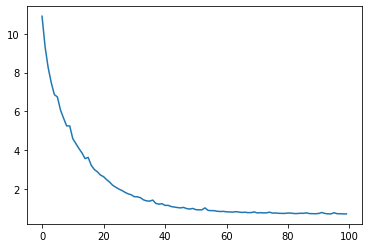

In [16]:
plt.plot(np.arange(len(val_losses)), val_losses)

In [17]:
#Maintenant pour améliorer le modèle on repère tout les hyper-paramètres et on construit une fonction qui simule l'entrainement pour une configuration
#Des hyper-paramètres

def train(alpha = 1e-5, epochs = 100) -> (nn.Module, list, list):
  """
  Perform the training on the x_tensor, y_tensor splitted.
  Params:
    - alpha : Learning rate
  Returns: 
    - R: Trained Model
    - losses: Training Losses
    - val_losses: Validation Losses
  """
  losses = []
  val_losses = []

  R = Regression(x_train_tensor.shape[1])
  optimizer = torch.optim.SGD(R.parameters(), lr=alpha)
  mse_loss = nn.MSELoss(reduction='mean')

  #On construit ce qui va faire avancer l'entrainement
  train_step = train_step_constructor(R,mse_loss, optimizer)

  for epoch in range(epochs):
    for batch_x,batch_y in train_loader:
      R.train()
      l = train_step(batch_x, batch_y)
      losses.append(l)
      R.eval()
      pred_val = R(x_test_tensor)
      val_loss = mse_loss(y_test_tensor.view((-1,)), pred_val.view((-1,)))
      val_losses.append(val_loss.item())

  return R, losses, val_losses

Final training loss  :  1.9588762521743774
Final validation loss :  2.3159260749816895


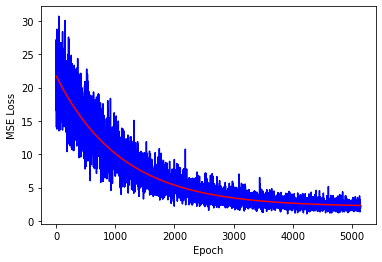

In [18]:
R, losses, val_losses = train(1e-8, 50)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.plot(np.arange(len(losses)),losses, label = "Training Loss", c = "blue")
plt.plot(np.arange(len(val_losses)),val_losses, label = "Testing Loss", c = "red")
print("Final training loss  : ",losses[-1])
print("Final validation loss : ", val_losses[-1])

Final training loss  :  0.6454904079437256
Final validation loss :  0.8089058995246887


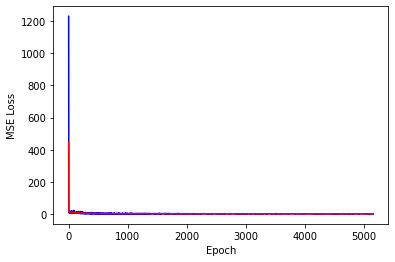

In [19]:
R, losses, val_losses = train(1e-5, 50)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.plot(np.arange(len(losses)),losses, label = "Training Loss", c = "blue")
plt.plot(np.arange(len(val_losses)),val_losses, label = "Testing Loss", c = "red")
print("Final training loss  : ",losses[-1])
print("Final validation loss : ", val_losses[-1])

In [20]:
R, losses, val_losses = train(1e-4, 50)
print("Final training loss  : ",losses[-1])
print("Final validation loss : ", val_losses[-1])

Final training loss  :  nan
Final validation loss :  nan


In [21]:
R, losses, val_losses = train(1e-5, 1000)
print("Final training loss  : ",losses[-1])
print("Final validation loss : ", val_losses[-1])

Final training loss  :  0.43543338775634766
Final validation loss :  0.6149798631668091


In [ ]:
#ça prend un peu trop de temps heureusement qu'on sait comment y remédier
def train(alpha = 1e-5, epochs = 100, device = "cpu") -> (nn.Module, list, list):
  """
  Perform the training on the x_tensor, y_tensor splitted.
  Params:
    - alpha : Learning rate
  Returns: 
    - R: Trained Model
    - losses: Training Losses
    - val_losses: Validation Losses
  """
  losses = []
  val_losses = []

  R = Regression(x_train_tensor.shape[1]).to(device)
  optimizer = torch.optim.SGD(R.parameters(), lr=alpha)
  mse_loss = nn.MSELoss(reduction='mean')

  train_step = train_step_constructor(R,mse_loss, optimizer)

  for epoch in range(epochs):
    for batch_x,batch_y in train_loader:
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
      R.train()
      l = train_step(batch_x, batch_y)
      losses.append(l)
      R.eval()
      pred_val = R(x_test_tensor.to(device))
      val_loss = mse_loss(y_test_tensor.view((-1,)).to(device), pred_val.view((-1,)).to(device))
      val_losses.append(val_loss.item())

  return R, losses, val_losses

In [ ]:
%timeit R, losses, val_losses = train(1e-5, 100,"cpu")
print("Final training loss  : ",losses[-1])
print("Final validation loss : ", val_losses[-1])

1 loop, best of 3: 7.54 s per loop
Final training loss  :  0.8137500882148743
Final validation loss :  0.6463591456413269


In [ ]:
%timeit R, losses, val_losses = train(1e-5, 100,"cuda:0")
print("Final training loss  : ",losses[-1])
print("Final validation loss : ", val_losses[-1])

1 loop, best of 3: 13.6 s per loop
Final training loss  :  0.8137500882148743
Final validation loss :  0.6463591456413269


In [ ]:
#Petit supplément, quand c'est long on aime bien avoir une indication de a quel point l'entrainement progresse
!pip install tqdm
from tqdm import tqdm

In [ ]:
def train(alpha = 1e-5, epochs = 100, device = "cpu") -> (nn.Module, list, list):
  """
  Perform the training on the x_tensor, y_tensor splitted.
  Params:
    - alpha : Learning rate
  Returns: 
    - R: Trained Model
    - losses: Training Losses
    - val_losses: Validation Losses
  """
  losses = []
  val_losses = []

  R = Regression(x_train_tensor.shape[1]).to(device)
  optimizer = torch.optim.SGD(R.parameters(), lr=alpha)
  mse_loss = nn.MSELoss(reduction='mean')

  train_step = train_step_constructor(R,mse_loss, optimizer)

  #on ajoute juste tqdm ici
  for epoch in tqdm(range(epochs)):
    for batch_x,batch_y in train_loader:
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
      R.train()
      l = train_step(batch_x, batch_y)
      losses.append(l)
      R.eval()
      pred_val = R(x_test_tensor.to(device))
      val_loss = mse_loss(y_test_tensor.view((-1,)).to(device), pred_val.view((-1,)).to(device))
      val_losses.append(val_loss.item())

  return R, losses, val_losses

In [ ]:
R, losses, val_losses = train(1e-5, 100)
print("\n Final training loss  : ",losses[-1])
print("Final validation loss : ", val_losses[-1])

100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


 Final training loss  :  0.9844934940338135
Final validation loss :  0.6632706522941589


In [ ]:
#On aimerait suivre l'évolution de la training loss pendant l'entrainement ! 
from tqdm.notebook import tqdm
def train(alpha = 1e-5, epochs = 100, device = "cpu") -> (nn.Module, list, list):
  """
  Perform the training on the x_tensor, y_tensor splitted.
  Params:
    - alpha : Learning rate
  Returns: 
    - R: Trained Model
    - losses: Training Losses
    - val_losses: Validation Losses
  """
  losses = []
  val_losses = []

  R = Regression(x_train_tensor.shape[1]).to(device)
  optimizer = torch.optim.SGD(R.parameters(), lr=alpha)
  mse_loss = nn.MSELoss(reduction='mean')

  train_step = train_step_constructor(R,mse_loss, optimizer)
  #ça c'est la barre du nombre d'epochs
  outer = tqdm(total=epochs, desc='Epochs', position=0)
  for epoch in range(epochs):
    #On crée une barre par epoch 
    inner = tqdm(total=len(train_loader), desc=f'Batch {epoch+1}', position=1)
    for batch_x,batch_y in train_loader:
      #On ajoute une étape d'entrainement
      inner.update(1)
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
      R.train()
      l = train_step(batch_x, batch_y)
      losses.append(l)
      R.eval()
      pred_val = R(x_test_tensor.to(device))
      val_loss = mse_loss(y_test_tensor.view((-1,)).to(device), pred_val.view((-1,)).to(device))
      val_losses.append(val_loss.item())

      #MAJ de l'affichage de l'epoch courant
      inner.set_postfix({'val_loss': val_loss.item(),'loss': l})
      ######
    #On ajoute le nombre d'epochs
    outer.update(1)

  return R, losses, val_losses

In [ ]:
R, losses, val_losses = train(1e-5, 100)

Final training loss  :  0.6023348569869995
Final validation loss :  0.6229023337364197


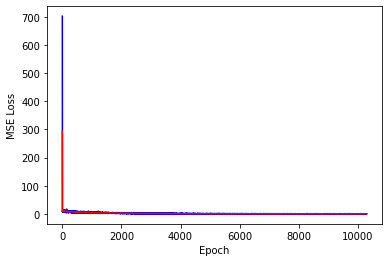

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.plot(np.arange(len(losses)),losses, label = "Training Loss", c = "blue")
plt.plot(np.arange(len(val_losses)),val_losses, label = "Testing Loss", c = "red")
print("Final training loss  : ",losses[-1])
print("Final validation loss : ", val_losses[-1])

In [ ]:
#Un dernier petit changement, on peut controler la taille du batch
from tqdm.notebook import tqdm
def train(alpha = 1e-5, epochs = 100, device = "cpu", batch_size = 100) -> (nn.Module, list, list):
  """
  Perform the training on the x_tensor, y_tensor splitted.
  Params:
    - alpha : Learning rate
  Returns: 
    - R: Trained Model
    - losses: Training Losses
    - val_losses: Validation Losses
  """
  losses = []
  val_losses = []

  R = Regression(x_train_tensor.shape[1]).to(device)
  optimizer = torch.optim.SGD(R.parameters(), lr=alpha)
  mse_loss = nn.MSELoss(reduction='mean')

  train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

  train_step = train_step_constructor(R,mse_loss, optimizer)
  #ça c'est la barre du nombre d'epochs
  outer = tqdm(total=epochs, desc='Epochs', position=0)
  for epoch in range(epochs):
    #On crée une barre par epoch 
    inner = tqdm(total=len(train_loader), desc=f'Batch {epoch+1}', position=1)
    for batch_x,batch_y in train_loader:
      #On ajoute une étape d'entrainement
      inner.update(1)
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
      R.train()
      l = train_step(batch_x, batch_y)
      losses.append(l)
      R.eval()
      pred_val = R(x_test_tensor.to(device))
      val_loss = mse_loss(y_test_tensor.view((-1,)).to(device), pred_val.view((-1,)).to(device))
      val_losses.append(val_loss.item())

      #MAJ de l'affichage de l'epoch courant
      inner.set_postfix({'val_loss': val_loss.item(),'loss': l})
      ######
    #On ajoute le nombre d'epochs
    outer.update(1)

  return R, losses, val_losses

In [ ]:
R, losses, val_losses = train(1e-5, 100, batch_size = 64)

## Feature Engineering


### Feature Selection

Pour me donner de l'inspiration sur quoi tester j'aime bien commencer par visualiser des stats.

Quels données ? commençons par check celles qui sont les plus corrélés avec ce que je veux prédire par exemple.

In [ ]:
#On se met les données sous les yeux
df

In [ ]:
corr = df.corr()
corr

In [ ]:
#On prend la colonne de la classe
#Rappel : pour manipuler un dataframe comme une liste ou un tableau numpy on utilise iloc
corr = corr["quality"].iloc[:-1]
corr

In [ ]:
#Je pourrais faire ça différemment mais ça me donne l'occasion de vous montrer comment executer une fonction sur tous les éléments

def part_pos(x):
  return x if x > 0 else -x

corr = corr.apply(part_pos)
corr

In [ ]:
#On les trie tant qu'a faire 
corr = corr.sort_values(ascending=False)

C'est que des chiffres tout ça donc faut normaliser.

In [ ]:
#On va normaliser en soustrayant le minimum et en divisant par l'écart entre le min et le max (y'a d'autres façons de le faire)
norm = lambda x: (x - corr.min()) / (corr.max() - corr.min())
corr = corr.apply(norm)

In [ ]:
#On retrie
corr = corr.sort_values(ascending=False)
corr

A priori je ne dirais pas qu'il y ait des variables vraiment mauvaises mais pour vous montrer comment on drop des colonnes je vais retirer tout ce qui est en dessous de 0.10 puis essayer de retirer tout ce qui est en dessous de 0.20

In [ ]:
#Je pourrais juste les écrire mais on peut faire ça aussi comme ça 
corr < 0.10

In [ ]:
corr[corr < 0.10]

In [ ]:
corr[corr < 0.10].keys()

In [ ]:
#Et ensuite on drop :
df2 = df.drop(corr[corr < 0.10].keys(), axis=1, inplace=False) #Attention au inplace

In [ ]:
df2

In [ ]:
def preprocessing(df2):
  arr = np.array(df2) #On transforme le df en tableau
  X = arr[: , :-1] #Toutes les lignes de toutes les colonnes sauf la dernière serons nos X
  y = arr[: , -1] #Toutes les lignes de la dernière colonne sera notre Y
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  x_train_tensor = torch.from_numpy(X_train).float()
  y_train_tensor = torch.from_numpy(y_train).float()
  x_test_tensor = torch.from_numpy(X_test).float()
  y_test_tensor = torch.from_numpy(y_test).float()
  train_data = TensorDataset(x_train_tensor, y_train_tensor)
  return train_data, x_test_tensor, y_test_tensor

In [ ]:
def train( R, train_data, X_test_tensor, y_test_tensor, alpha = 1e-5, epochs = 100, device = "cpu", batch_size = 100) -> (nn.Module, list, list):
  """
  Perform the training on the x_tensor, y_tensor splitted.
  Params:
    - alpha : Learning rate
  Returns: 
    - R: Trained Model
    - losses: Training Losses
    - val_losses: Validation Losses
  """
  losses = []
  val_losses = []
  optimizer = torch.optim.SGD(R.parameters(), lr=alpha)
  mse_loss = nn.MSELoss(reduction='mean')
  train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
  train_step = train_step_constructor(R,mse_loss, optimizer)
  outer = tqdm(total=epochs, desc='Epochs', position=0)
  for epoch in range(epochs):
    inner = tqdm(total=len(train_loader), desc=f'Batch {epoch+1}', position=1)
    for batch_x,batch_y in train_loader:
      inner.update(1)
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
      R.train()
      l = train_step(batch_x, batch_y)
      losses.append(l)
      R.eval()
      pred_val = R(x_test_tensor.to(device))
      val_loss = mse_loss(y_test_tensor.view((-1,)).to(device), pred_val.view((-1,)).to(device))
      val_losses.append(val_loss.item())
      inner.set_postfix({'val_loss': val_loss.item(),'loss': l})
    outer.update(1)

  return R, losses, val_losses

In [ ]:
tdata, x_test_tensor, y_test_tensor = preprocessing(df2)
tdata

In [ ]:
R = Regression(x_train_tensor.shape[1])
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 100, device = "cpu", batch_size = 64)

Bon sur cette run en particulier ça marche pas super, je pourrais faire des stats sur une moyenne sur plein de runs mais la je suis juste entrain de tatonner donc je vais me contenter de re-executer quelque fois pour voire.

In [ ]:
R = Regression(x_train_tensor.shape[1])
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 100, device = "cpu", batch_size = 64)

Sachant qu'on a 2 attributs en moins ça a l'air suffisamment intéressant pour que je continue d'exploiter cette piste.

### Data Normalization

Je peux essayer de normaliser chaque colonne pour voire si ça impacte l'entrainement (généralement c'est le cas)

In [42]:
#Je réecrie la fonction de tout a l'heure avec une option qui permet de normaliser
def preprocessing(df2, normalize = False):
  arr = np.array(df2)
  X = arr[: , :-1]
  y = arr[: , -1]
  ##Ici on normalize les x donc on parcours les colonnes et on soustrait a chaque fois le min et on divise par le max-min
  if(normalize):
    for i in range(X.shape[1]):
      min_x = X[: , i].min()
      max_x = X[:, i].max()
      X[: , i] = (X[: , i] - min_x)/(max_x - min_x)
  ####
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  x_train_tensor = torch.from_numpy(X_train).float()
  y_train_tensor = torch.from_numpy(y_train).float()
  x_test_tensor = torch.from_numpy(X_test).float()
  y_test_tensor = torch.from_numpy(y_test).float()
  train_data = TensorDataset(x_train_tensor, y_train_tensor)
  return train_data, x_test_tensor,y_test_tensor

In [ ]:
tdata, x_test_tensor, y_test_tensor = preprocessing(df2, normalize=False)
x_test_tensor

In [ ]:
tdata, x_test_tensor, y_test_tensor = preprocessing(df2, normalize=True)
x_test_tensor

In [ ]:
R = Regression(x_train_tensor.shape[1])
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 100, device = "cpu", batch_size = 64)

Intéressant de voire que la normalisation stabilise l'entrainement mais le ralentit donc on peut se permettre un alpha un peu plus grand.

In [ ]:
R = Regression(x_train_tensor.shape[1])
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 100, alpha = 1e-2, device = "cpu", batch_size = 64)

Voila on a une legère amélioration,

Testons sur l'autre ensemble sans les colonnes en moins.

In [ ]:
tdata, x_test_tensor, y_test_tensor = preprocessing(df, normalize=True)
R = Regression(x_test_tensor.shape[1])
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 100, alpha = 1e-2, device = "cpu", batch_size = 64)

ça se voit pas sur le notebook mais a chaque fois je lance deux trois fois, et la c'est très comparable donc je vais continuer de trainer les deux ensembles on sait jamais que plus tard la différence de colonnes puisse me sauver d'un sur-apprentissage ou autre.

## Approfondir le modèle

Bon maintenant on peut commencer a proposer des nouveaux modèles 

In [ ]:
class DH1_Regression(nn.Module):
    def __init__(self, n_in, hidden1, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        self.h1 = nn.Linear(n_in, hidden1, bias = True)
        self.o = nn.Linear(hidden1, 1, bias = True)
               
    def forward(self, x):
      x = self.relu(self.h1(x))
      return self.o(x)

In [ ]:
x_test_tensor.shape[1]

In [ ]:
tdata, x_test_tensor, y_test_tensor = preprocessing(df, normalize=True)
R = DH1_Regression(x_test_tensor.shape[1],22 )
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 100, alpha = 1e-2, device = "cpu", batch_size = 64)

In [ ]:
tdata, x_test_tensor, y_test_tensor = preprocessing(df, normalize=True)
R = DH1_Regression(x_test_tensor.shape[1],44)
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 250, alpha = 1e-3, device = "cpu", batch_size = 64)

In [ ]:
tdata, x_test_tensor, y_test_tensor = preprocessing(df2, normalize=True)
R = DH1_Regression(x_test_tensor.shape[1],44)
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 300, alpha = 2e-3, device = "cpu", batch_size = 64)

Ok donc a priori on fera pas mieux que 0.565 avec ce modèle.

In [ ]:
class DH2_Regression(nn.Module):
    def __init__(self, n_in, hidden1, hidden2, p =0.1):
        super().__init__()
        self.relu = nn.ReLU()
        self.h1 = nn.Linear(n_in, hidden1, bias = True)
        self.h2 = nn.Linear(hidden1, hidden2, bias = True)
        self.o = nn.Linear(hidden2, 1, bias = True)

    def forward(self, x):
      x = self.relu(self.h1(x))
      x = self.relu(self.h2(x))
      return self.o(x)

In [ ]:
tdata, x_test_tensor, y_test_tensor = preprocessing(df2, normalize=True)
R = DH2_Regression(x_test_tensor.shape[1],22,44)
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 300, alpha = 1e-3, device = "cpu", batch_size = 64)

In [ ]:
tdata, x_test_tensor, y_test_tensor = preprocessing(df2, normalize=True)
R = DH2_Regression(x_test_tensor.shape[1],120,240)
m, loss, val_loss = train(R, tdata, x_test_tensor, y_test_tensor, epochs = 300, alpha = 1e-3, device = "cpu", batch_size = 64)

Voila déja la on arrive a faire quasi 2 fois mieux que le benchmark et pour un tutoriel improvisé en 24h c'est suffisant.

## Autres conseils

## A propos du téléchargement de données

Certaines données ne sont pas directement en CSV, certaines données sont compréssées etc...

Ce genre de petit problèmes nécessiterons que vous manipuliez le système d'exploitation en utilisant la commande "!" et des fois que vous écriviez un "parser" c'est a dire une fonction qui construit le dataframe a partir du fichier ou de son contenu.

In [ ]:
#Exemple (le plus compliqué de ceux d'en haut)
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat

In [ ]:
!ls

In [ ]:
def parse(file):
  with open(file, "r") as f:
    lines = f.readlines()
    arr = []
    for line in lines:
      line  = line.strip() #Enlève l'espace/ retour a la fin de chaque ligne
      vals = line.split("\t") #On divise selon le séparateur (ici une tabulation)
      vals  = np.array(vals).astype(float) #On cast tout en float dans un np.array
      arr.append(vals) #On concatène
    #On fini le travail en castant le grand tableau qui contient tout les petits tableaux
    arr = np.array(arr)
    print(arr.shape) #On vérifie la shape
    df = pd.DataFrame(arr) 
    #Eventuellement nommer les colonnes en utilisant cette syntaxe
    #df.columns = ["nom1", "nom2", ... ] mais flemme
    return (df)

parse("airfoil_self_noise.dat")

## A propos de certains prétraitements

Un prétraitement que je n'ai pas eu l'occasion de montrer dans l'exemple est celui des données **catégoriques**.

En effet, un réseau de neurones peut interpréter un réel comme une valeur d'importance (et encore mieux si il est normalisé) ou un booléen (présence ou abscence de quelque chose) mais imaginons qu'on ait affaire a une valeur catégorique dans les attributs comme un pays : Algérie, Argentine, Bresil Argentine, etc... 

Alors il faut recourir a deux prétraitements

### Label encoding
Cette étape consiste a construire une liste des termes pouvant apparaitre dans la colonne qu'on veut traiter (ici des pays) et ensuite on remplace dans la colonne le pays par son numéro dans la liste.

L'exemple précédent deviens : 0,1,2,1,...

### One-Hot-Encoding

Ce prétraitement permet de passer d'une colonne de valeurs catégoriques a plusieurs colonnes a valeurs booléennes (compliqué je sais mais l'exemple va l'éclaircir)

## Discrétisation
Parfois le fait qu'une valeur soit continue plûtot que discrete complexifie le modèle pour rien donc on peut transformer une colonne de valeurs continues en valeurs discrètes si on juge que ça rend mieux compte de l'état de ce qui décris la colonne.


Maintenant prenons pour le dataset "White Wine" un exemple de chaque prétraitement.


In [ ]:
df

In [ ]:
#On va discretiser "fixed_acidity"
arr = df["fixed acidity"].values #On récupère un tableau numpy 
arr

In [ ]:
#On prend le min et le max 
arr_min = arr.min()
arr_max = arr.max()
arr_min, arr_max

In [ ]:
#Maintenant disons qu'on veut 30 classes
bins = np.linspace(arr_min, arr_max, 30)
bins

In [ ]:
#Maintenant pour associer a chaque élément une classe je cherche l'argmax du vecteur booléen de cette comparaison
(bins < arr[5])

In [ ]:
(bins < arr[5]).astype(int)

In [ ]:
(bins < arr[5]).astype(int).argmin() #ça c'est le premier indice pour lequel la valeur est minimale (vaut 0)

In [ ]:
#On en fais une lambda
get_bin = lambda x, bins:(bins < x).astype(int).argmin()
get_bin(arr[5],bins)

In [ ]:
df["fixed acidity"].apply(get_bin, bins = bins)

In [ ]:
#Et on remplace inplace
df_disc = pd.DataFrame(df)
df_disc["fixed acidity"] = df["fixed acidity"].apply(get_bin, bins = bins)

In [ ]:
df_disc

In [ ]:
df_disc.describe()

In [ ]:
dum = pd.get_dummies(df_disc["fixed acidity"]) #ça ça nous retourne le one hot encoding 

In [ ]:
df_disc = df_disc.drop("fixed acidity",axis = 1) #on retire l'ancienne colonne

In [ ]:
#Et on colle dum avec df_disc
df_disc = dum.join(df_disc)
df_disc

# Multi-classe classification


In [47]:
class MulticlassClassification(nn.Module):
  
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [36]:
qualities = np.unique(np.array(df.quality))
qualtoid = lambda x:np.argmax([qualities == x])
qualities

array([3, 4, 5, 6, 7, 8, 9])

In [37]:
qualtoid(5)

2

In [40]:
df["quality"]

0       6
1       6
2       6
3       6
4       6
       ..
4893    6
4894    5
4895    6
4896    7
4897    6
Name: quality, Length: 4898, dtype: int64

In [44]:
df_class = pd.DataFrame(df)
df_class["quality"] = df["quality"].apply(qualtoid)
df_class["quality"]

0       0
1       0
2       0
3       0
4       0
       ..
4893    0
4894    0
4895    0
4896    1
4897    0
Name: quality, Length: 4898, dtype: int64

In [45]:
train_data, x_test_tensor,y_test_tensor = preprocessing(df_class)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [59]:
losses = []
val_losses = []

model = MulticlassClassification(num_feature = len(df.columns)-1, num_class=len(qualities))

optimizer = torch.optim.Adam(R.parameters(), lr=1e-5)
mlc_loss = nn.CrossEntropyLoss(reduction='mean')

#On construit ce qui va faire avancer l'entrainement
train_step = train_step_constructor(model ,mlc_loss, optimizer)

for epoch in range(5):
    model.train()
    for batch_x,batch_y in train_loader:
      print(batch_y)
      with torch.no_grad():
        m = nn.Softmax(dim=1)
        print(m(model(batch_x)))
      break

tensor([6., 4., 6., 5., 6., 7., 4., 7., 7., 5., 7., 6., 7., 6., 6., 6., 6., 5.,
        5., 7., 6., 7., 6., 5., 6., 7., 7., 7., 7., 8., 8., 5.])
tensor([[0.0643, 0.1028, 0.1425, 0.0941, 0.1703, 0.2403, 0.1857],
        [0.0556, 0.0362, 0.3657, 0.0371, 0.1583, 0.2259, 0.1213],
        [0.0804, 0.1311, 0.1143, 0.2515, 0.1034, 0.1627, 0.1566],
        [0.0860, 0.0970, 0.1674, 0.0737, 0.2683, 0.1349, 0.1726],
        [0.1301, 0.0912, 0.1702, 0.1249, 0.1150, 0.1313, 0.2373],
        [0.1296, 0.1759, 0.1819, 0.0789, 0.1578, 0.1065, 0.1694],
        [0.1104, 0.1406, 0.1592, 0.1381, 0.1801, 0.1801, 0.0914],
        [0.1064, 0.0995, 0.1444, 0.1031, 0.2150, 0.1695, 0.1621],
        [0.1314, 0.0611, 0.1141, 0.1142, 0.1609, 0.2215, 0.1968],
        [0.1114, 0.1177, 0.1547, 0.1566, 0.0966, 0.2064, 0.1566],
        [0.1328, 0.1023, 0.1123, 0.1196, 0.1265, 0.1927, 0.2138],
        [0.1307, 0.1436, 0.1094, 0.1380, 0.1472, 0.1450, 0.1862],
        [0.1116, 0.0939, 0.1688, 0.0976, 0.1906, 0.1762, 0.1613